## Importing Libraries

In [16]:
!pip install -q gdown

In [17]:
import re
import gdown
import pickle
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Dataset

In [18]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [19]:
!kaggle datasets download -d kazanova/sentiment140 -p /tmp/

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
local_training_zip = '/tmp/sentiment140.zip'
if zipfile.is_zipfile(local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()

In [21]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [22]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [23]:
df = pd.read_csv('/tmp/training.1600000.processed.noemoticon.csv', sep=',', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Preprocessing Data

### Removing unwanted data

In [24]:
df.drop(columns=["ids", "date", "flag", "user"], inplace=True)

In [25]:
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...
1599995,4,Just woke up. Having no school is the best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


### Preprocess text

+ [Text Preprocessing: Handle Emoji & Emoticon](https://studymachinelearning.com/text-preprocessing-handle-emoji-emoticon/)

In [26]:
EMOTICON_DICT_PATH = '/tmp/Emoticon_Dict.p'

In [27]:
gdown.download(url='https://drive.google.com/uc?id=1HDpafp97gCl9xZTQWMgP2kKK_NuhENlE', output=EMOTICON_DICT_PATH, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1HDpafp97gCl9xZTQWMgP2kKK_NuhENlE
To: /tmp/Emoticon_Dict.p
100%|██████████| 3.48k/3.48k [00:00<00:00, 1.37MB/s]


'/tmp/Emoticon_Dict.p'

In [28]:
with open(EMOTICON_DICT_PATH, 'rb') as fp:
    emoticon_dict = pickle.load(fp)
emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in emoticon_dict) + u')')

In [29]:
def process_txt(text, emoticon_pattern):
    # handling mentions, links, hashtags
    txt = re.sub(pattern=r"(?:\@|\#|https?\://)\S+", repl="", string=text)
    txt = re.sub(pattern=r'\w+.com\s?', repl='', string=txt)

    # handling emoticons
    txt = emoticon_pattern.sub(repl=r'', string=txt)

    # handling spaces
    txt = txt.strip()
    txt = re.sub(pattern=r'  ', repl=' ', string=txt)

    # removing words of length one
    txt = ' '.join([w for w in txt.split() if len(w)>1])
    return txt

In [30]:
df['text'] = df['text'].apply(func=process_txt, emoticon_pattern=emoticon_pattern)

In [31]:
df

,target,text
0,0,"Awww, that's bummer. You shoulda got David Carr of Third Day to do it."
1,0,is upset that he can't update his Facebook by texting it... and might cry as result School today also. Blah!
2,0,dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am here? because can't see you all over there."
...,...,...
1599995,4,Just woke up. Having no school is the best feeling ever
1599996,4,Very cool to hear old Walt interviews! â«
1599997,4,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


### Splitting dataset

In [32]:
X = df['text'].values
Y = df['target'].values

### Preprocess labels

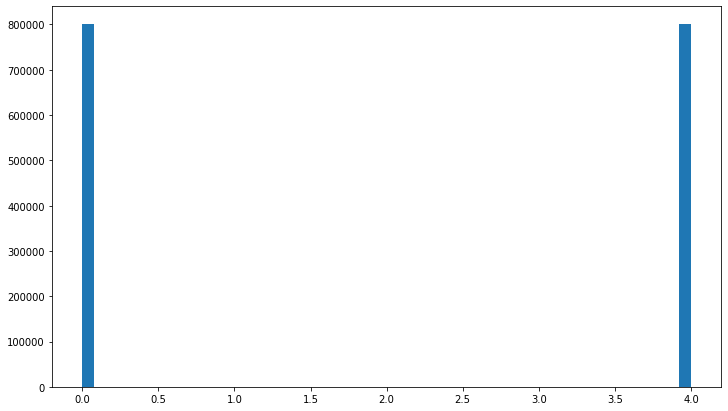

In [33]:
plt.figure(figsize=(12, 7))
plt.hist(x=Y, bins=50);

In [34]:
np.unique(ar=Y)

array([0, 4])

In [35]:
Y = np.array(list(map(int, Y>0)))
Y

array([0, 0, 0, ..., 1, 1, 1])

## Tokenization

In [36]:
words = []
for sentence in X:
    for word in sentence.split():
        words.append(word)
words = list(set(words))
print('No. of unique words:', len(words))

No. of unique words: 889298


In [37]:
VOCAB_SIZE = 5000

In [38]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None
)

In [39]:
tokenizer.fit_on_texts(texts=X)

In [40]:
tokenizer.word_index

{'to': 1,
 'the': 2,
 'my': 3,
 'and': 4,
 'you': 5,
 'is': 6,
 'it': 7,
 'in': 8,
 'for': 9,
 'of': 10,
 'on': 11,
 'me': 12,
 'so': 13,
 'have': 14,
 'that': 15,
 'but': 16,
 "i'm": 17,
 'just': 18,
 'with': 19,
 'be': 20,
 'at': 21,
 'not': 22,
 'was': 23,
 'this': 24,
 'now': 25,
 'up': 26,
 'good': 27,
 'day': 28,
 'out': 29,
 'all': 30,
 'get': 31,
 'like': 32,
 'are': 33,
 'no': 34,
 'go': 35,
 'quot': 36,
 'today': 37,
 'do': 38,
 "it's": 39,
 'too': 40,
 'your': 41,
 'work': 42,
 'going': 43,
 'love': 44,
 'got': 45,
 'lol': 46,
 'time': 47,
 'back': 48,
 'from': 49,
 'what': 50,
 'one': 51,
 'know': 52,
 'will': 53,
 'we': 54,
 'about': 55,
 'im': 56,
 'really': 57,
 "don't": 58,
 'am': 59,
 'amp': 60,
 'had': 61,
 'can': 62,
 'see': 63,
 'some': 64,
 "can't": 65,
 'its': 66,
 'if': 67,
 'still': 68,
 'well': 69,
 'night': 70,
 'want': 71,
 'new': 72,
 'think': 73,
 'how': 74,
 'home': 75,
 'thanks': 76,
 'oh': 77,
 'when': 78,
 'as': 79,
 'there': 80,
 'more': 81,
 'off': 82

In [41]:
seq = tokenizer.texts_to_sequences(texts=X)

In [42]:
mx = -1
for i in seq:
    mx = max(mx, len(i))
print('Max. length of sequence:', mx)

Max. length of sequence: 50


## Padding

In [43]:
MAX_LENGTH = 50
PADDING_TYPE = 'post'
TRUNCATING_TYPE = 'post'

In [44]:
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=seq,
    maxlen=MAX_LENGTH,
    padding=PADDING_TYPE,
    truncating=TRUNCATING_TYPE
)

padded_seq

array([[ 446,  135, 1184, ...,    0,    0,    0],
       [   6,  778,   15, ...,    0,    0,    0],
       [ 304,  344,    9, ...,    0,    0,    0],
       ...,
       [  33,    5,  199, ...,    0,    0,    0],
       [ 112,  260,    1, ...,    0,    0,    0],
       [ 112,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [45]:
padded_seq.shape

(1600000, 50)

## Creating Model

In [61]:
class DCNN():

    def __init__(self, vocab_size, input_len, batch_size, emb_dim=128, nb_filters=50, ffn_units=512, nb_classes=2, dropout_rate=0.2):
        self.vocab_size = vocab_size
        self.input_len = input_len
        self.emb_dim = emb_dim
        self.nb_filters = nb_filters
        self.ffn_units = ffn_units
        self.nb_classes = nb_classes
        self.dropout_rate = dropout_rate

    
    def build(self):
        input_x = tf.keras.Input(shape=self.input_len, name='Inputs')

        # Input: (batch_size, input_len) => Output: (batch_size, input_len, output_dim)
        x = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.emb_dim, input_length=self.input_len, name='Embeddings')(input_x)

        # Input: (batch_size, steps, input_dim) => Output: (batch_size, new_steps, filters)
        x1 = tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=2, strides=1, padding='valid', activation='relu', name='Bigram')(x)
        # Input: (batch_size, steps, features) => Output: (batch_size, features)
        x1 = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='Bipool')(x1)

        # Input: (batch_size, steps, input_dim) => Output: (batch_size, new_steps, filters)
        x2 = tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=3, strides=1, padding='valid', activation='relu', name='Trigram')(x)
        # Input: (batch_size, steps, features) => Output: (batch_size, features)
        x2 = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='Tripool')(x2)

        # Input: (batch_size, steps, input_dim) => Output: (batch_size, new_steps, filters)
        x3 = tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=4, strides=1, padding='valid', activation='relu', name='Quadgram')(x)
        # Input: (batch_size, steps, features) => Output: (batch_size, features)
        x3 = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='Quadpool')(x3)

        # Output: (batch_size, 3*nb_filters)
        x = tf.concat(values=[x1, x2, x3], axis=-1, name='Merge')

        # Input: (batch_size, input_dim) => Output: (batch_size, units)
        x = tf.keras.layers.Dense(units=self.ffn_units, activation='relu', name='Dense')(x)
        x = tf.keras.layers.Dropout(rate=self.dropout_rate, name='DropOut')(x)

        if self.nb_classes == 1 or self.nb_classes == 2:
            output_dense = tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output')(x)
        else:
            output_dense = tf.keras.layers.Dense(units=self.nb_classes, activation='softmax', name='Output')(x)

        return tf.keras.Model(inputs=input_x, outputs=output_dense, name='DCNN')

## Initiating Model

In [62]:
NB_CLASSES = 2
BATCH_SIZE = 128
EPOCHS = 10

In [63]:
dcnn = DCNN(vocab_size=VOCAB_SIZE, emb_dim=128, input_len=MAX_LENGTH, batch_size=BATCH_SIZE, nb_filters=50, ffn_units=512, 
            nb_classes=NB_CLASSES, dropout_rate=0.2)
dcnn_model = dcnn.build()

In [70]:
dcnn_model.summary(line_length=125)

Model: "DCNN"
_____________________________________________________________________________________________________________________________
Layer (type)                             Output Shape               Param #        Connected to                              
Inputs (InputLayer)                      [(None, 50)]               0                                                        
_____________________________________________________________________________________________________________________________
Embeddings (Embedding)                   (None, 50, 128)            640000         Inputs[0][0]                              
_____________________________________________________________________________________________________________________________
Bigram (Conv1D)                          (None, 49, 50)             12850          Embeddings[0][0]                          
________________________________________________________________________________________________________

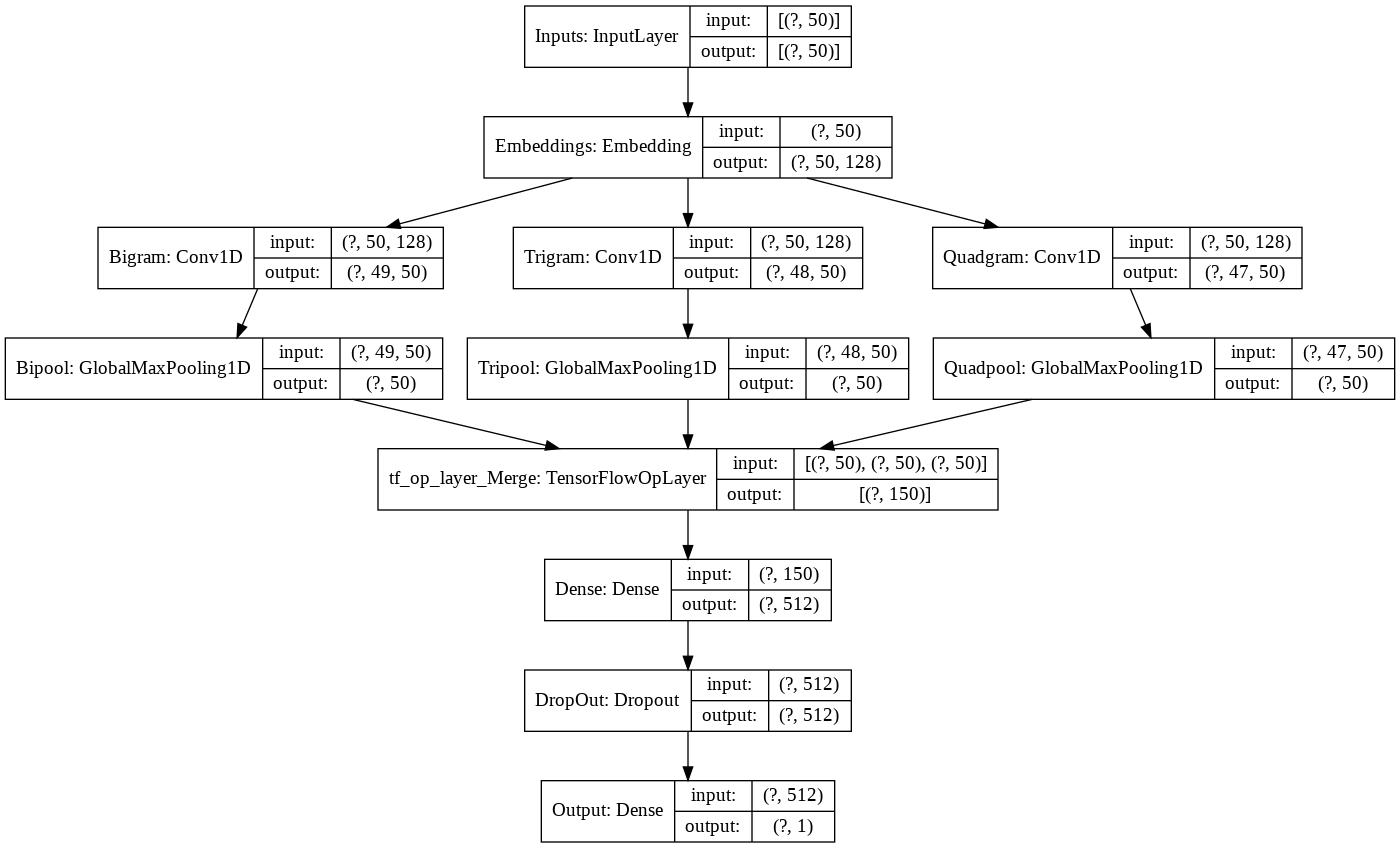

In [66]:
tf.keras.utils.plot_model(
    model = dcnn_model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

## Compiling Model

In [ ]:
if NB_CLASSES == 2:
    dcnn.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])
else:
    dcnn.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['sparse_categorical_accuracy'])

## Training Model

In [ ]:
history = dcnn.fit(
    x=padded_seq,
    y=Y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.4080 - acc: 0.8136 - val_loss: 0.5992 - val_acc: 0.7048
Epoch 2/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.3780 - acc: 0.8302 - val_loss: 0.6339 - val_acc: 0.6765
Epoch 3/10
10000/10000 [==============================] - 96s 10ms/step - loss: 0.3629 - acc: 0.8381 - val_loss: 0.5817 - val_acc: 0.7222
Epoch 4/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3505 - acc: 0.8447 - val_loss: 0.5583 - val_acc: 0.7263
Epoch 5/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3395 - acc: 0.8506 - val_loss: 0.5708 - val_acc: 0.7184
Epoch 6/10
10000/10000 [==============================] - 97s 10ms/step - loss: 0.3297 - acc: 0.8552 - val_loss: 0.6051 - val_acc: 0.7084
Epoch 7/10
10000/10000 [==============================] - 98s 10ms/step - loss: 0.3206 - acc: 0.8598 - val_loss: 0.5559 - val_acc: 0.7258
Epoch 8/10
10000/10000 [==========

## Analyzing Model

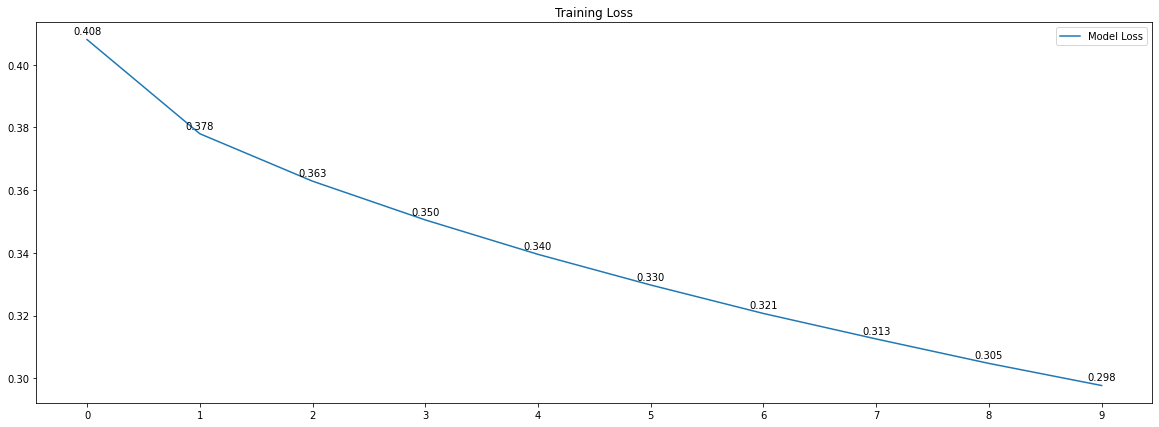

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(history.epoch, history.history['loss'], label='Model Loss')
plt.legend()
plt.title('Training Loss')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['loss']):
    label = "{:.3f}".format(y)
    plt.annotate(label,                              # this is the text
                (x, y),                              # this is the point to label
                textcoords="offset points",          # how to position the text
                xytext=(0, 5),                       # distance from text to points (x,y)
                ha='center')                         # horizontal alignment can be left, right or center